In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

# Toy example

# 1. Prepare data

## 1-(1) Load the data(checkpoints_eoc.csv)

In [2]:
# load the data
check_eoc = pd.read_csv("C:/Users/rroos/OneDrive/바탕 화면/Data/Random Sample of Data Files/checkpoints_eoc.csv")

# Select one book
check_eoc_abcd = check_eoc[check_eoc['book'] == "College / Advanced Statistics and Data Science (ABCD)"]

# Select the column needed(student_id, EOC(score), chapter_number)
check_eoc_abcd = check_eoc_abcd[["student_id", "EOC", "chapter_number"]]

check_eoc_abcd[0:20]

,student_id,EOC,chapter_number
12,041a771b-41cc-4b36-928d-ec321f918db5,0.566667,1
13,041a771b-41cc-4b36-928d-ec321f918db5,0.673469,2
14,041a771b-41cc-4b36-928d-ec321f918db5,0.541667,3
15,041a771b-41cc-4b36-928d-ec321f918db5,0.549020,5
16,041a771b-41cc-4b36-928d-ec321f918db5,0.512195,6
17,041a771b-41cc-4b36-928d-ec321f918db5,0.678571,7
18,041a771b-41cc-4b36-928d-ec321f918db5,0.710526,8
19,041a771b-41cc-4b36-928d-ec321f918db5,0.446154,9
20,041a771b-41cc-4b36-928d-ec321f918db5,0.785714,10
21,041a771b-41cc-4b36-928d-ec321f918db5,0.367089,11


## 1-(2) Data cleaning(make students score complete - n chapters)

In [3]:
def fill_missing_chapters(group, chap_num):
    '''
    Making the student's score complete(n number of chapters in this book)
    Compute the NAs of scores if applicable
    '''
    # Set the chapter_number as an index
    group.set_index('chapter_number', inplace = True)
    # Change the index from 1 to the number of chapter
    group = group.reindex(range(1, chap_num+1))
    # Impute NA with mean
    group['EOC'].fillna(group['EOC'].mean(), inplace = True)
    return group

# Find the maximum number of chapter(varied between books)
chap_num = max(check_eoc_abcd['chapter_number'])

# Set the student_id as an index
check_eoc_abcd.set_index('student_id', inplace=True)

# Groupby with student_id and apply fil_missing_chapters function
grouped_abcd = check_eoc_abcd.groupby('student_id').apply(fill_missing_chapters, chap_num)

# Reset the index(Make it cleaner)
grouped_abcd.reset_index(inplace=True)

grouped_abcd[0:20]

,student_id,chapter_number,EOC
0,041a771b-41cc-4b36-928d-ec321f918db5,1,0.566667
1,041a771b-41cc-4b36-928d-ec321f918db5,2,0.673469
2,041a771b-41cc-4b36-928d-ec321f918db5,3,0.541667
3,041a771b-41cc-4b36-928d-ec321f918db5,4,0.591916
4,041a771b-41cc-4b36-928d-ec321f918db5,5,0.549020
5,041a771b-41cc-4b36-928d-ec321f918db5,6,0.512195
6,041a771b-41cc-4b36-928d-ec321f918db5,7,0.678571
7,041a771b-41cc-4b36-928d-ec321f918db5,8,0.710526
8,041a771b-41cc-4b36-928d-ec321f918db5,9,0.446154
9,041a771b-41cc-4b36-928d-ec321f918db5,10,0.785714


In [4]:
# Save the file
grouped_abcd.to_csv('cleaned_sample_eoc.csv')

## 1-(3) Formating the data into arrays

In [5]:
# Each component consist of each student
EOC = np.array(grouped_abcd['EOC']).reshape(-1, chap_num)
EOC.shape

(82, 16)

In [6]:
EOC[0:3]

array([[0.56666667, 0.67346939, 0.54166667, 0.59191563, 0.54901961,
        0.51219512, 0.67857143, 0.71052632, 0.44615385, 0.78571429,
        0.36708861, 0.68      , 0.59191563, 0.59191563, 0.59191563,
        0.59191563],
       [0.925     , 0.86363636, 0.87      , 0.875     , 0.93333333,
        0.83      , 0.8125    , 0.82191781, 0.75      , 0.63235294,
        0.71232877, 0.77333333, 0.81661688, 0.81661688, 0.81661688,
        0.81661688],
       [0.6       , 0.58474576, 0.54676259, 0.62318841, 0.63076923,
        0.50413223, 0.5       , 0.47435897, 0.50485437, 0.43283582,
        0.44303797, 0.6625    , 0.54098361, 0.46031746, 0.54166667,
        0.47222222]])

# 2. Modeling

## 2-(1) Regression

In [31]:
# Create a dictionary to save models
models = {}

for seq_len in range(1, chap_num):
    # Create training data which have 1 scores, 2 scores, ... chap_num of scores
    X_train = EOC[:, :seq_len]
    # chap_num+1 th data that we want to predict
    y_train = EOC[:, seq_len]
    
    # Model initialization and training
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Save the model
    models[seq_len] = model

    
def predict_next_score(input_scores):
    '''
    Given the scores, predict the next score
    '''
    seq_len = len(input_scores)
    model = models.get(seq_len)
    
    # Predict the next score
    input_array = np.array(input_scores).reshape(1, -1)
    next_score = model.predict(input_array)
    
    return next_score[0]

## Generalized Version of Regression Model + Visualization

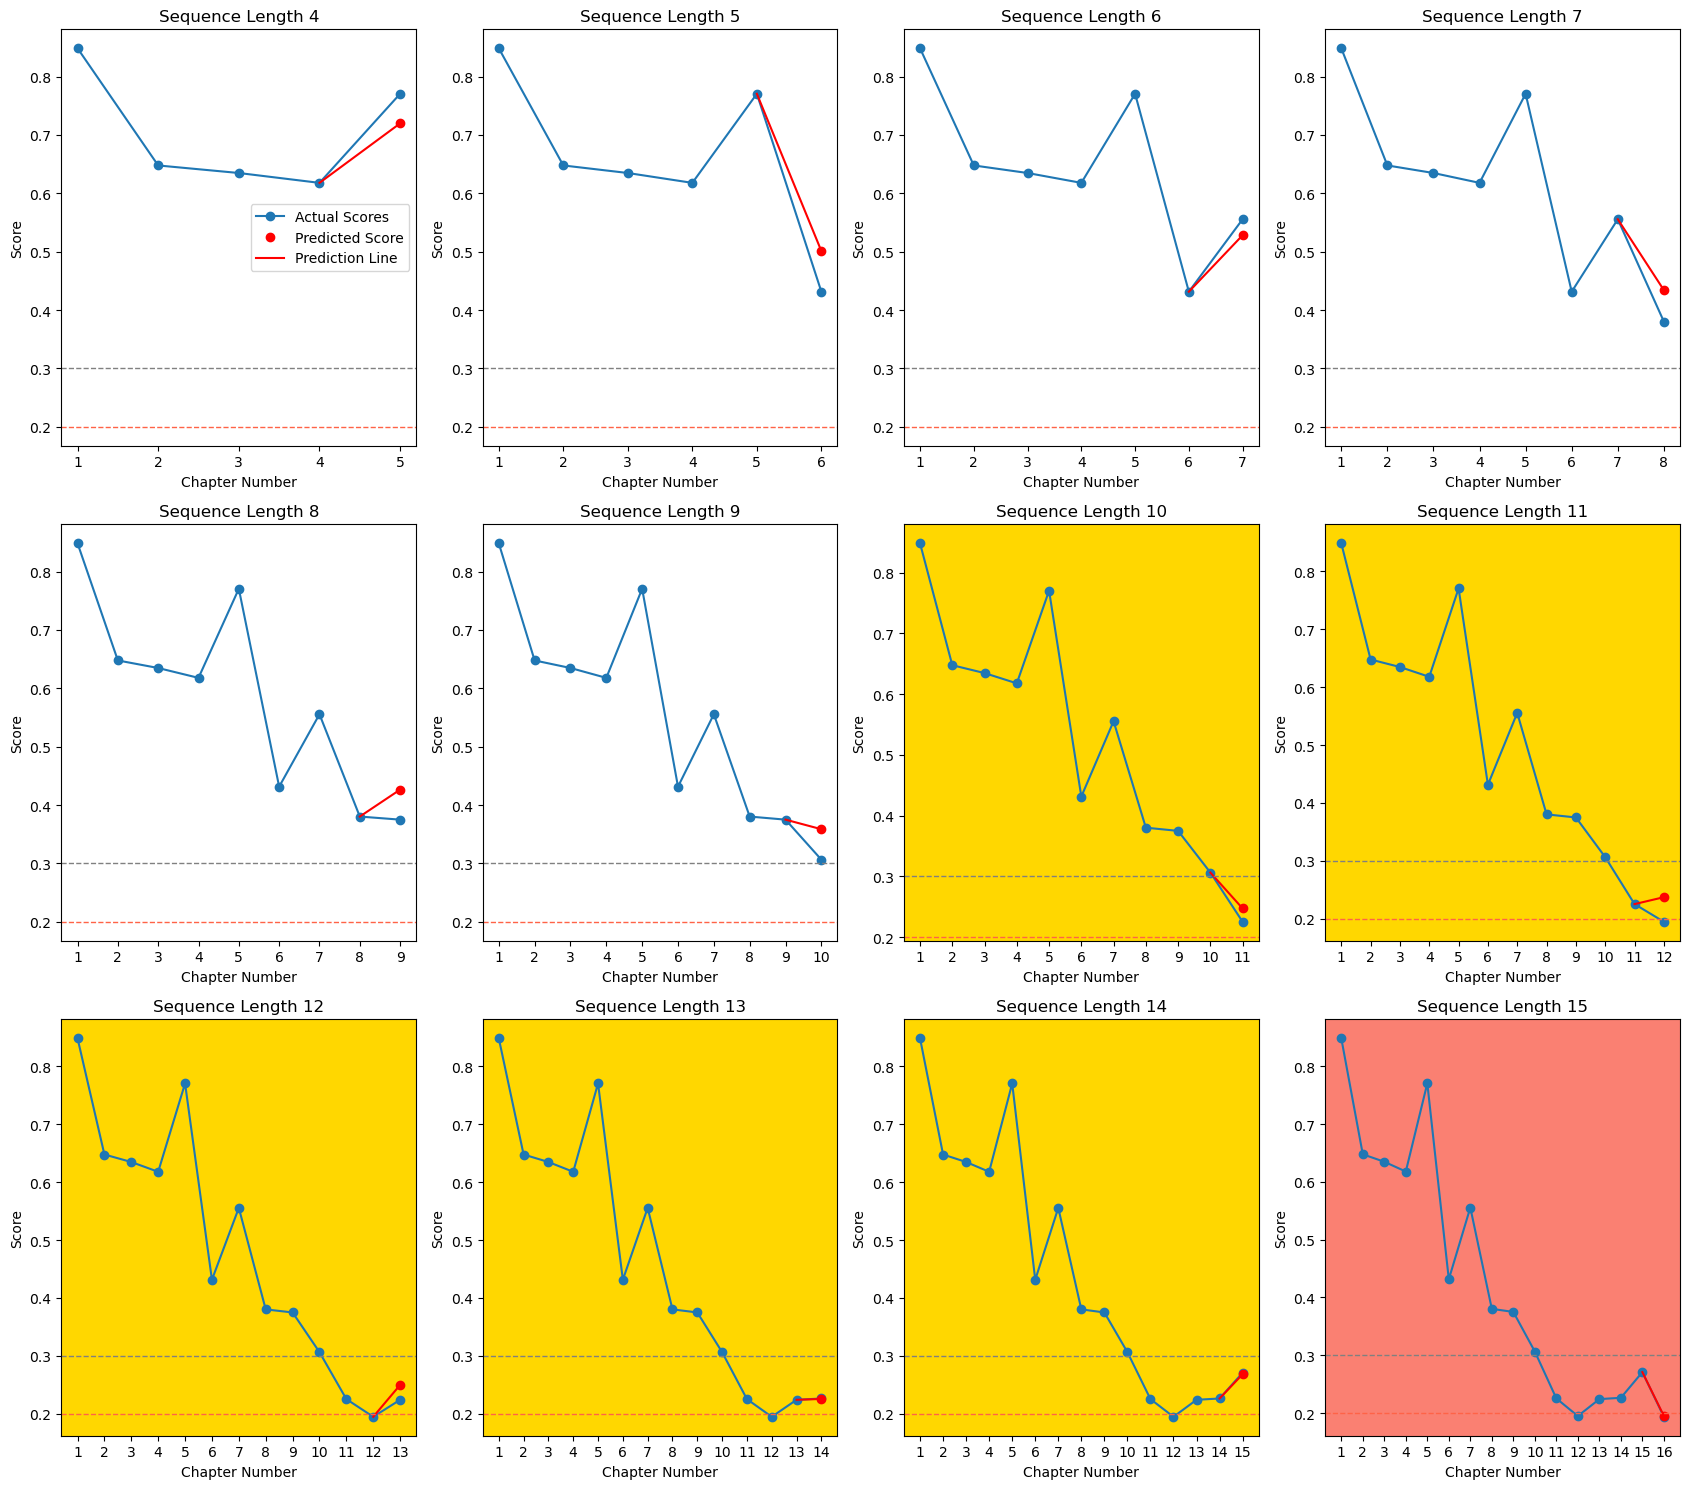

In [32]:
def new(id):
    # New data
    stu = grouped_abcd[grouped_abcd['student_id'] == id]
    stu.set_index('student_id', inplace=True)
    # Groupby with student_id and apply fil_missing_chapters function
    stu = stu.groupby('student_id').apply(fill_missing_chapters, chap_num)
    # Reset the index(Make it cleaner)
    stu.reset_index(inplace=True)
    return stu
    
stu = new('5f7aee38-fac6-4ddb-9c0f-38a5e2706d66')
    
# Visualize
fig, axes = plt.subplots(3, 4, figsize=(17, 15))  # 4x3 subplots
axes = axes.ravel()

# Create new data
stu = np.array(stu["EOC"])

# Set the cutoff
tier1 = 0.2
tier2 = 0.3

for i, seq_len in enumerate(range(4, chap_num)):
    model = models[seq_len]  # Adjust the index if necessary, based on your models list

    # Create new data of length seq_len
    scores_to_predict = stu[:seq_len].reshape(1, -1)
    predicted_score = model.predict(scores_to_predict).flatten()  # Flatten to ensure it's a 1D array

    scores = stu[:seq_len + 1]  # All actual scores up to seq_len

    # Draw the line graph
    axes[i].plot(range(1, seq_len + 2), scores, marker='o', label='Actual Scores')
    axes[i].set_title(f'Sequence Length {seq_len}')
    axes[i].set_xlabel('Chapter Number')
    axes[i].set_ylabel('Score')
    axes[i].set_xticks(np.array(range(1, seq_len + 2)))

    # Add the predicted value as a red dot
    if predicted_score.size > 0:  # Check if predicted_score is not empty
        axes[i].plot(seq_len + 1, predicted_score[0], 'ro', label='Predicted Score')  # Plot only the first element

        # Connect the last real score to the predicted score with a red line
        if seq_len > 0:
            last_real_value = scores[-2]  # Last real score
            axes[i].plot([seq_len, seq_len + 1], [last_real_value, predicted_score[0]], 'r-', label='Prediction Line')
            
        # Check predicted_score and set background color
        if predicted_score[0] < tier1:
            axes[i].set_facecolor('salmon')  # If the predicted score is below 0.2, set background to red
        elif predicted_score[0] < tier2:
            axes[i].set_facecolor('gold')  # If the predicted score is below 0.3 but above 0.2, set background to yellow
            
            
    # Add a horizontal dotted line at y=0.5
    axes[i].axhline(y=tier1, color='tomato', linestyle='--', linewidth=1)
    axes[i].axhline(y=tier2, color='gray', linestyle='--', linewidth=1)

    # Add legend only on the first subplot or based on your preference
    if i == 0:
        axes[i].legend()

plt.tight_layout()
plt.show()

# 3. Assess the Model

In [20]:
# Convert scores to class labels based on the defined tiers
def score_to_class(score, tier1, tier2):
    if score >= tier2:
        return 0  # Above tier2, set as class 0
    elif score >= tier1:
        return 1  # Between tier1 and tier2, set as class 1
    else:
        return 2  # Below tier1, set as class 2

# Apply this function to your actual scores to create true class labels
true_classes = np.array([score_to_class(score, tier1, tier2) for score in stu])

# Initialize a list to store predicted classes
predicted_classes = []

for seq_len in range(4, chap_num):
    model = models[seq_len]
    
    # Create new data of length seq_len
    scores_to_predict = stu[:seq_len].reshape(1, -1)
    predicted_score = model.predict(scores_to_predict).flatten()  # Flatten to ensure it's a 1D array
    
    # Predict class based on the predicted score
    predicted_class = score_to_class(predicted_score[0], tier1, tier2)
    predicted_classes.append(predicted_class)

# Calculate the accuracy
accuracy = accuracy_score(true_classes[4:chap_num], predicted_classes)
print(f"Accuracy of the model as a classifier: {accuracy:.2f}")

Accuracy of the model as a classifier: 0.92


# Real Data

## 1. Data prepare

In [21]:
# load the data
full_eoc = pd.read_csv("C:/Users/rroos/OneDrive/바탕 화면/Data/Full Data/checkpoints_eoc.csv")

# Select one book
full_eoc_abcd = full_eoc[full_eoc['book'] == "College / Advanced Statistics and Data Science (ABCD)"]

# Select the column needed(student_id, EOC(score), chapter_number)
full_eoc_abcd = full_eoc_abcd[["student_id", "EOC", "chapter_number"]]

# Eliminate students that have duplicate chapters
duplicates = full_eoc_abcd.groupby(['student_id', 'chapter_number']).size().reset_index(name='count')
duplicate_students = duplicates[duplicates['count'] > 1]['student_id'].unique()
full_eoc_abcd = full_eoc_abcd[~full_eoc_abcd['student_id'].isin(duplicate_students)]

unique_students = full_eoc_abcd['student_id'].unique()
train_students, test_students = train_test_split(unique_students, test_size=0.2, random_state=42)

# Split the data based on the student_id groups
train_data = full_eoc_abcd[full_eoc_abcd['student_id'].isin(train_students)]
test_data = full_eoc_abcd[full_eoc_abcd['student_id'].isin(test_students)]

train_students[0:5]
train_data[0:20]

# Find the maximum number of chapter(varied between books)
chap_num = max(full_eoc_abcd['chapter_number'])

# Set the student_id as an index
train_data.set_index('student_id', inplace=True)

# Groupby with student_id and apply fil_missing_chapters function
train_data_grouped = train_data.groupby('student_id').apply(fill_missing_chapters, chap_num)

# Reset the index(Make it cleaner)
train_data_grouped.reset_index(inplace=True)

# Set the student_id as an index
test_data.set_index('student_id', inplace=True)

# Groupby with student_id and apply fil_missing_chapters function
test_data_grouped = test_data.groupby('student_id').apply(fill_missing_chapters, chap_num)

# Reset the index(Make it cleaner)
test_data_grouped.reset_index(inplace=True)

In [22]:
# Save file
full_eoc_abcd.to_csv('cleaned_full_eoc.csv')

In [23]:
train_data_grouped

,student_id,chapter_number,EOC
0,016e2fcf-0cc2-42ad-844d-e1057b5081cc,1,0.854545
1,016e2fcf-0cc2-42ad-844d-e1057b5081cc,2,0.772727
2,016e2fcf-0cc2-42ad-844d-e1057b5081cc,3,0.813636
3,016e2fcf-0cc2-42ad-844d-e1057b5081cc,4,0.813636
4,016e2fcf-0cc2-42ad-844d-e1057b5081cc,5,0.813636
...,...,...,...
6619,ff6ec9fe-de1d-4b45-8136-59465d9c85ab,12,0.531646
6620,ff6ec9fe-de1d-4b45-8136-59465d9c85ab,13,0.677419
6621,ff6ec9fe-de1d-4b45-8136-59465d9c85ab,14,0.517857
6622,ff6ec9fe-de1d-4b45-8136-59465d9c85ab,15,0.272727


In [24]:
test_data_grouped

,student_id,chapter_number,EOC
0,0096491a-77bf-4e79-b906-fc7a8e5e57a6,1,0.636364
1,0096491a-77bf-4e79-b906-fc7a8e5e57a6,2,0.580952
2,0096491a-77bf-4e79-b906-fc7a8e5e57a6,3,0.765217
3,0096491a-77bf-4e79-b906-fc7a8e5e57a6,4,0.583333
4,0096491a-77bf-4e79-b906-fc7a8e5e57a6,5,0.426667
...,...,...,...
1659,fd3993c4-9c4d-44ec-a266-00e142403b27,12,0.800000
1660,fd3993c4-9c4d-44ec-a266-00e142403b27,13,0.847115
1661,fd3993c4-9c4d-44ec-a266-00e142403b27,14,0.847115
1662,fd3993c4-9c4d-44ec-a266-00e142403b27,15,0.847115


In [25]:
# Each component consist of each student
train_EOC = np.array(train_data_grouped['EOC']).reshape(-1, chap_num)
test_EOC = np.array(test_data_grouped['EOC']).reshape(-1, chap_num)
train_EOC.shape, test_EOC.shape

((414, 16), (104, 16))

## 2. Modeling

### Train the model

In [26]:
imputer = SimpleImputer(strategy='mean')

# Impute missing values in train_EOC
train_EOC_imputed = imputer.fit_transform(train_EOC)

models = {}

for seq_len in range(1, chap_num):
    # Create training data which have 1 score, 2 scores, ... chap_num of scores
    X_train = train_EOC_imputed[:, :seq_len]
    # The next data point that we want to predict
    y_train = train_EOC_imputed[:, seq_len]

    # Check if y_train contains NaN values and remove corresponding rows
    mask = ~np.isnan(y_train)
    X_train, y_train = X_train[mask], y_train[mask]

    # Model initialization and training
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Save the model
    models[seq_len] = model

## 3. Assessing the Model

In [27]:
accuracies = {}

# Loop over sequence lengths
for seq_len in range(4, chap_num):
    model = models.get(seq_len)

    # Predict for the test set
    X_test = test_EOC[:, :seq_len]
    y_test = test_EOC[:, seq_len]
    y_pred = model.predict(X_test)

    # Convert the predictions and actual values to classes
    y_test_classes = np.array([score_to_class(y, tier1, tier2) for y in y_test])
    y_pred_classes = np.array([score_to_class(y, tier1, tier2) for y in y_pred])

    # Calculate and store the accuracy for this sequence length
    accuracies[seq_len] = accuracy_score(y_test_classes, y_pred_classes)

# Output the accuracy for each sequence length
for seq_len, accuracy in accuracies.items():
    print(f"Accuracy for sequence length {seq_len}: {accuracy:.2f}")

Accuracy for sequence length 4: 0.94
Accuracy for sequence length 5: 0.94
Accuracy for sequence length 6: 0.95
Accuracy for sequence length 7: 0.96
Accuracy for sequence length 8: 0.93
Accuracy for sequence length 9: 0.93
Accuracy for sequence length 10: 0.88
Accuracy for sequence length 11: 0.93
Accuracy for sequence length 12: 0.88
Accuracy for sequence length 13: 0.92
Accuracy for sequence length 14: 0.91
Accuracy for sequence length 15: 0.89


### Draw the feature importance

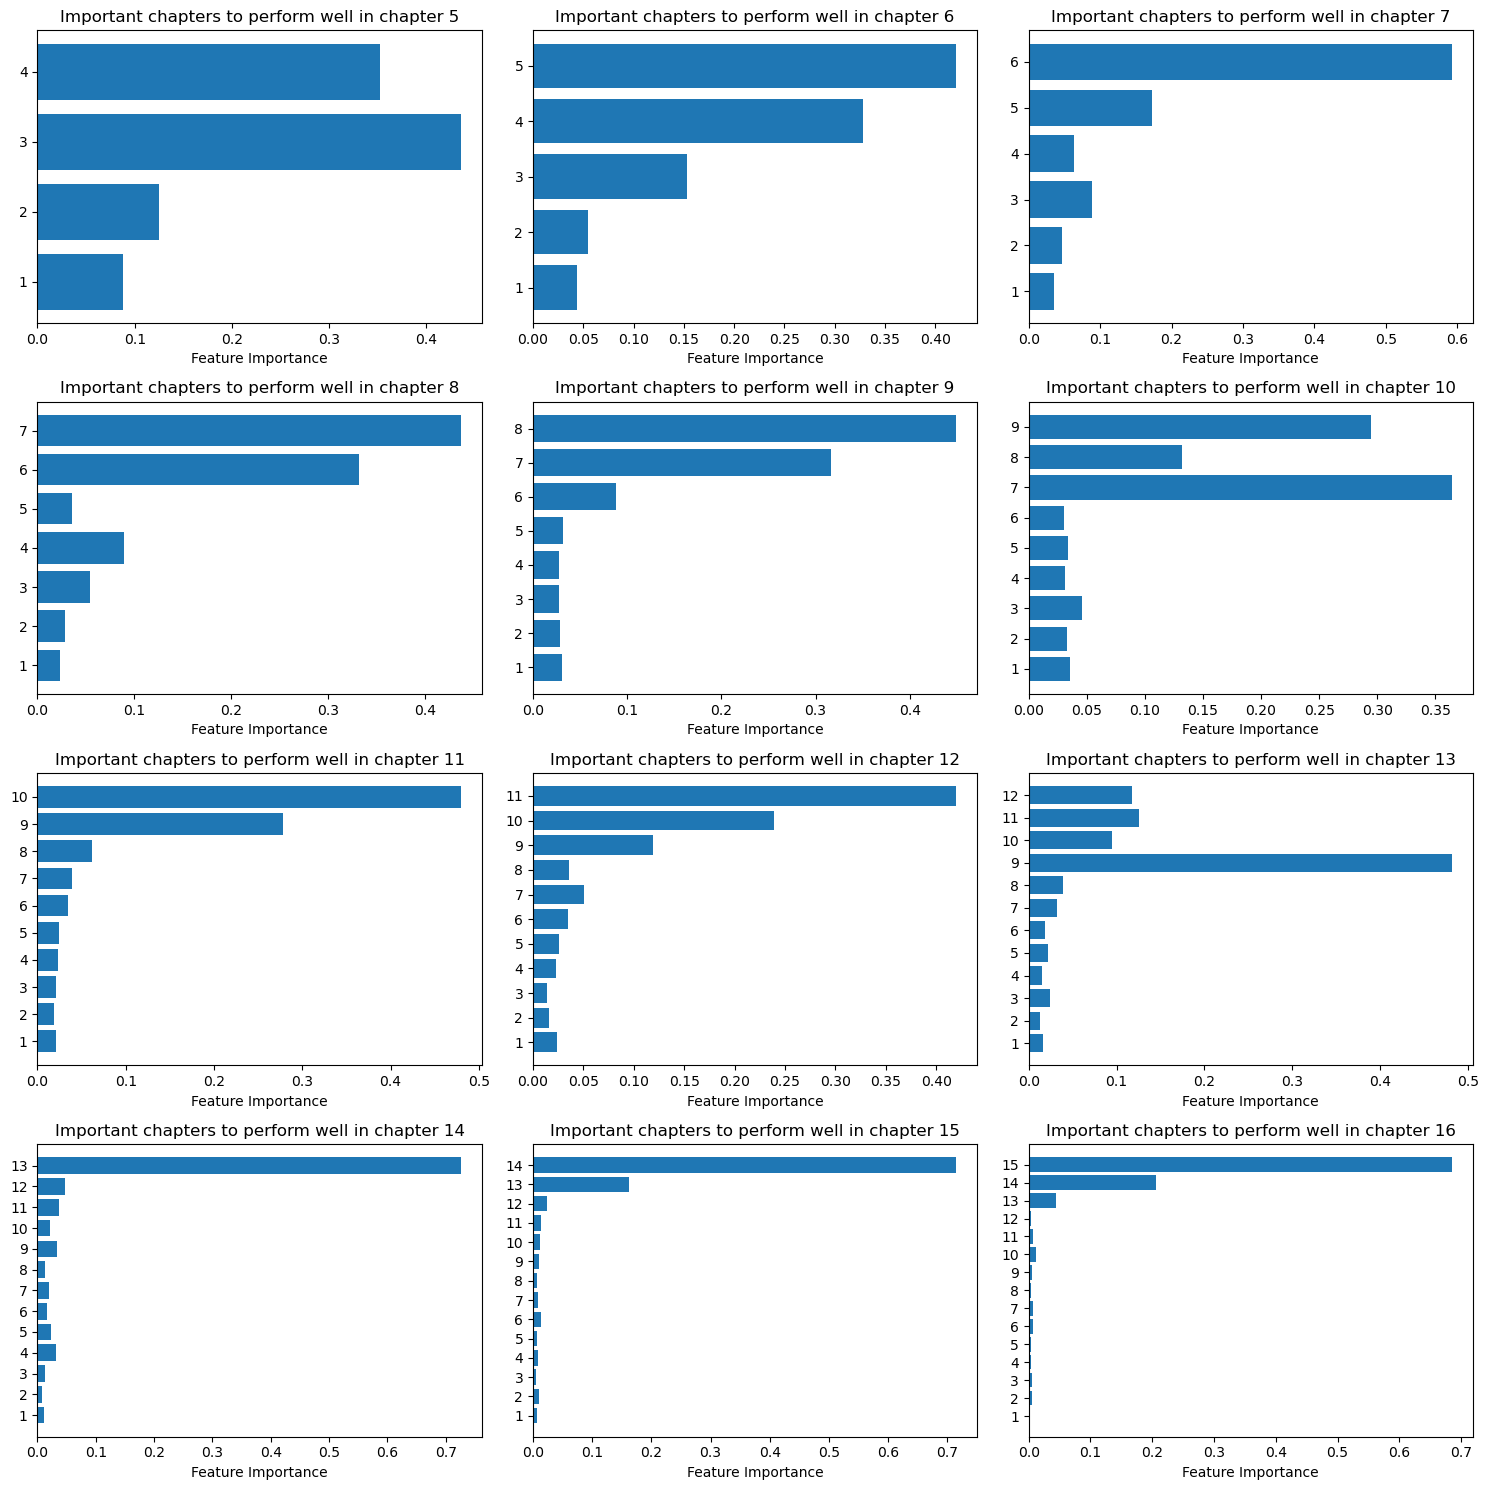

In [270]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))  # 4x3 subplots
axes = axes.ravel()

for i, seq_len in enumerate(range(4, chap_num)):
    model = models[seq_len]
    importances = model.feature_importances_
    
    axes[i].set_title(f'Important chapters to perform well in chapter {seq_len+1}')
    axes[i].barh(range(seq_len), importances, align='center')
    axes[i].set_yticks(range(seq_len))
    axes[i].set_yticklabels(np.arange(1, seq_len + 1))
    axes[i].set_xlabel('Feature Importance')

plt.tight_layout()
plt.show()